In [17]:
!pip install wordcloud

In [18]:
import pandas as pd
from tqdm import tqdm
import time
from concurrent.futures import ThreadPoolExecutor
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
import matplotlib.pyplot as plt
from textwrap import wrap
from wordcloud import WordCloud

# Descargar las stopwords y modelos de NLTK si aún no lo has hecho
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# Leemos los dataframes
tweets = pd.read_csv('tweets_limpios_esp_vacios2.csv',sep=',')

In [5]:
# Cargar el modelo de lenguaje BERT pre-entrenado en español
model_name = "dccuchile/bert-base-spanish-wwm-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Definir una función para realizar el análisis de sentimientos con BERT
def analyze_sentiment_bert(text):
    result = classifier(text)
    sentiment_label = result[0]["label"]
    
    if sentiment_label == "LABEL_0":
        sentiment = "Neutral"
    elif sentiment_label == "LABEL_1":
        sentiment = "Positivo"
    elif sentiment_label == "LABEL_2":
        sentiment = "Negativo"
    else:
        sentiment = "Desconocido"  # Maneja etiquetas desconocidas si es necesario
    
    return sentiment

# Función para preprocesar el texto (tokenización, lematización y eliminación de stopwords)
def preprocess_text(text):
    # Tokenización
    words = word_tokenize(text)
    
    # Lematización
    stemmer = SnowballStemmer('spanish')
    lemmatized_tokens = [stemmer.stem(word) for word in words]
    
    # Eliminación de stop words
    stop_words = set(stopwords.words('spanish'))
    filtered_tokens = [word for word in lemmatized_tokens if word.lower() not in stop_words]
    
    # Reconstrucción del texto preprocesado
    preprocessed_text = ' '.join(filtered_tokens)
    
    return preprocessed_text

# Función para realizar el análisis de sentimientos y preprocesamiento
def analyze_sentiment_and_preprocess(tweet):
    # Preprocesar el texto
    preprocessed_text = preprocess_text(tweet)
    
    # Realizar el análisis de sentimientos con BERT
    sentiment = analyze_sentiment_bert(preprocessed_text)
    
    return preprocessed_text, sentiment

# Función para aplicar el análisis de sentimientos y preprocesamiento en paralelo
def analyze_sentiment_parallel(column):
    with ThreadPoolExecutor(max_workers=4) as executor:
        results = list(tqdm(executor.map(analyze_sentiment_and_preprocess, column), total=len(column), desc="Analizando Sentimientos y Preprocesando"))
    return results

# Medir el tiempo de inicio
start_time = time.time()

# Aplicar el análisis de sentimientos y preprocesamiento en paralelo a la columna "Tweet Limpio"
preprocessed_data = analyze_sentiment_parallel(tweets['Tweet Limpio'])

# Separar los resultados en las columnas "Tweet Preprocesado" y "Sentimiento BERT"
tweets['Tweet Preprocesado NLTK'], tweets['Sentimiento BERT'] = zip(*preprocessed_data)

# Medir el tiempo de finalización
end_time = time.time()

# Calcular el tiempo total de ejecución
total_time = end_time - start_time

# Guardar el DataFrame resultante con los textos preprocesados y sentimientos en un nuevo archivo CSV
tweets.to_csv('tweets_con_sentimientos_BERT.csv', index=False)

# Imprimir el tiempo total de ejecución
print(f"Tiempo total de ejecución: {total_time} segundos")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['classifier.bias', 'bert.pooler.dense.weight', 'classifier.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Analizando Sentimientos y Preprocesando: 100%|███████████████████████████████| 443442/443442 [1:49:39<00:00, 67.39it/s]


Tiempo total de ejecución: 6586.276916742325 segundos


In [3]:
# Cargar el modelo de lenguaje BERT pre-entrenado en español
model_name = "dccuchile/bert-base-spanish-wwm-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Definir una función para realizar el análisis de sentimientos con BERT
def analyze_sentiment_bert(text):
    result = classifier(text)
    sentiment = result[0]["label"]
    return sentiment

# Aplicar tokenización, lematización y eliminación de stop words a la columna 'Tweet Limpio'
def preprocess_text(text):
    # Tokenización
    words = word_tokenize(text)
    
    # Lematización
    stemmer = SnowballStemmer('spanish')
    lemmatized_tokens = [stemmer.stem(word) for word in words]
    
    # Eliminación de stop words
    stop_words = set(stopwords.words('spanish'))
    filtered_tokens = [word for word in lemmatized_tokens if word.lower() not in stop_words]
    
    # Reconstrucción del texto preprocesado
    preprocessed_text = ' '.join(filtered_tokens)
    
    return preprocessed_text

with tqdm(total=len(tweets)) as pbar:
    tweets['Tweet Procesado NLTK'] = tweets['Tweet Limpio'].apply(lambda x: preprocess_text(x))
    pbar.update(len(tweets))

# Realizar el análisis de sentimientos en paralelo
def analyze_sentiment_parallel(column):
    with ThreadPoolExecutor(max_workers=4) as executor:
        result = list(tqdm(executor.map(analyze_sentiment_bert, column), total=len(column), desc="Analizando Sentimientos"))
    return result

# Medir el tiempo de inicio
start_time = time.time()

# Aplicar el análisis de sentimientos en paralelo a la columna 'Tweet Procesado'
tweets['Sentimiento BERT'] = analyze_sentiment_parallel(tweets['Tweet Procesado NLTK'])

# Medir el tiempo de finalización
end_time = time.time()

# Calcular el tiempo total de ejecución
total_time = end_time - start_time

# Guardar el DataFrame resultante con los sentimientos analizados en un nuevo archivo CSV
tweets.to_csv('tweets_con_sentimientos_BERT.csv', index=False)

# Imprimir el tiempo total de ejecución
print(f"Tiempo total de ejecución: {total_time} segundos")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['classifier.bias', 'bert.pooler.dense.bias', 'classifier.weight', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Analizando Sentimientos: 100%|███████████████████████████████████████████████| 443442/443442 [1:55:57<00:00, 63.74it/s]


Tiempo total de ejecución: 6970.055291652679 segundos


In [7]:
tweets['Sentimiento BERT'].head(200)

0      Positivo
1      Positivo
2      Positivo
3      Positivo
4      Positivo
         ...   
195    Positivo
196    Positivo
197    Positivo
198    Positivo
199    Positivo
Name: Sentimiento BERT, Length: 200, dtype: object

In [8]:
# Contar el número de tweets positivos
tweets_positivos = tweets[tweets['Sentimiento BERT'] == 'Positivo']

# Calcular el porcentaje de tweets positivos
porcentaje_positivos = (len(tweets_positivos) / len(tweets)) * 100

print(f"Porcentaje de tweets positivos: {porcentaje_positivos:.2f}%")

Porcentaje de tweets positivos: 99.68%


In [9]:
# Contar el número de tweets negativos
tweets_negativos = tweets[tweets['Sentimiento BERT'] == 'Negativo']

# Calcular el porcentaje de tweets negativos
porcentaje_negativos = (len(tweets_negativos) / len(tweets)) * 100

print(f"Porcentaje de tweets negativos: {porcentaje_negativos:.2f}%")

Porcentaje de tweets negativos: 0.00%


In [10]:
# Contar el número de tweets neutrales
tweets_neutrales = tweets[tweets['Sentimiento BERT'] == 'Neutral']

# Calcular el porcentaje de tweets negativos
porcentaje_neutrales = (len(tweets_neutrales) / len(tweets)) * 100

print(f"Porcentaje de tweets negativos: {porcentaje_neutrales:.2f}%")

Porcentaje de tweets negativos: 0.32%


In [11]:
# Tabla que muestra la frecuencia de cada sentimiento para cada valor único de nombre_bd
tabla = pd.crosstab(tweets['Nombre BD'], tweets['Sentimiento BERT'])
print(tabla)

Sentimiento BERT                     Neutral  Positivo
Nombre BD                                             
Cantantes_Colombianos                    113     39449
Deportistas_Colombianos                  131     41488
Empresas_Colombianas                     101     40242
Famosos                                  124     44288
Futbol_Colombiano                         99     41196
Instituciones_del_Estado_Colombiano      187     47479
Medios_Informaticos                      150     55676
Periodistas                              211     46474
Politicos_Colombianos                    237     45667
Universidades_Colombianas                 69     40061


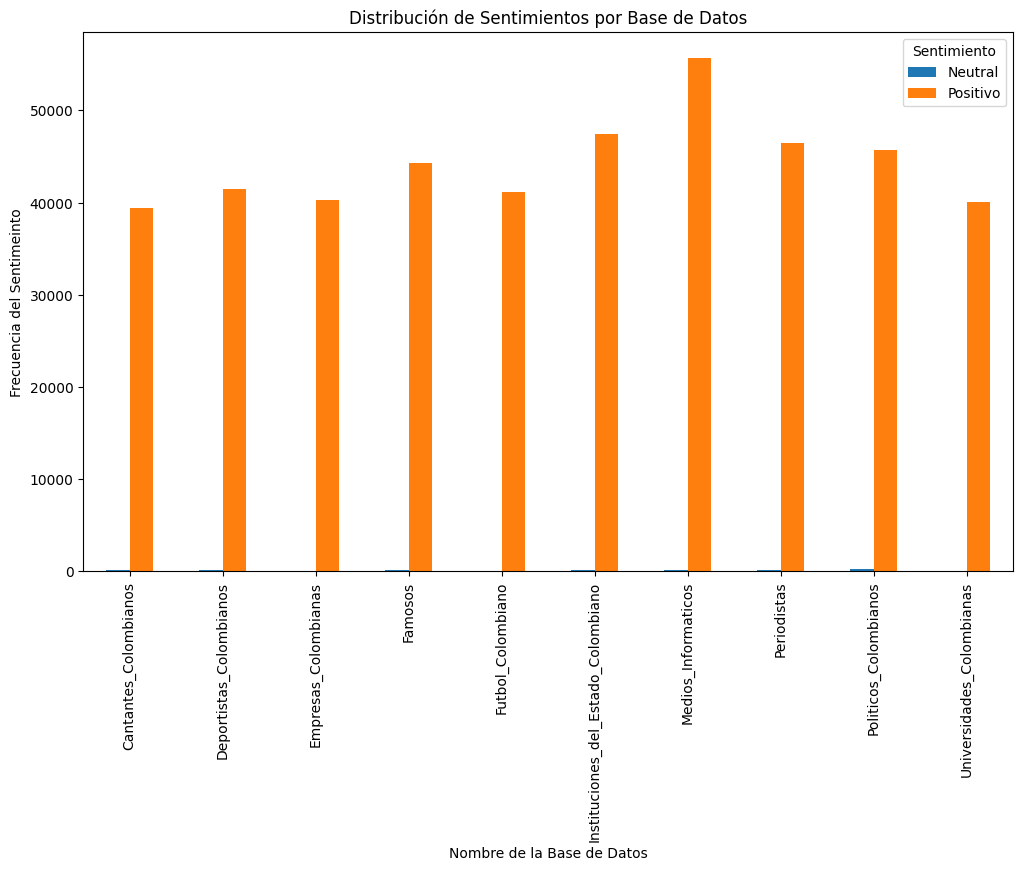

In [12]:
# Gráfico de barras agrupadas para visualizar la distribución
tabla.plot(kind='bar', figsize=(12, 7))
plt.title('Distribución de Sentimientos por Base de Datos')
plt.xlabel('Nombre de la Base de Datos')
plt.ylabel('Frecuencia del Sentimeinto')
plt.legend(title='Sentimiento', loc='upper right')
plt.show()

In [14]:
# Nube de Palabras por cada Sentimiento
# Filtra los tweets por categoría de sentimiento
tweets_positivos = tweets[tweets['Sentimiento BERT'] == 'Positivo']['Tweet Preprocesado NLTK'].tolist()
tweets_negativos = tweets[tweets['Sentimiento BERT'] == 'Negativo']['Tweet Preprocesado NLTK'].tolist()
tweets_neutrales = tweets[tweets['Sentimiento BERT'] == 'Neutral']['Tweet Preprocesado NLTK'].tolist()

In [15]:
# Función para crear y mostrar nubes de palabras
def generar_y_mostrar_nube_de_palabras(texto, categoria):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(texto))
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Nube de Palabras - ' + categoria)
    plt.axis('off')
    plt.show()

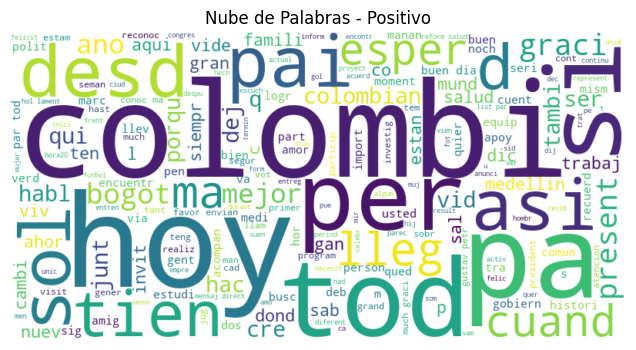

In [19]:
# Generar y mostrar nubes de palabras para Tweets Positivos
generar_y_mostrar_nube_de_palabras(tweets_positivos, "Positivo")

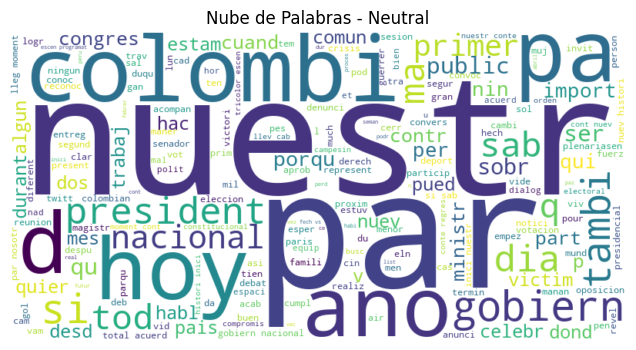

In [20]:
# Generar y mostrar nubes de palabras para Tweets Neutrales
generar_y_mostrar_nube_de_palabras(tweets_neutrales, "Neutral")